In [70]:
import os
from shutil import rmtree
import math
import random
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split
from constant import CANDLES_HISTORY
from add_indicators import get_column_indicators

In [71]:
if os.path.exists("resources/model"):
    rmtree("resources/model")
if os.path.exists("resources/parameters"):
    rmtree("resources/parameters")
if os.path.exists("logs/fit"):
    rmtree("logs/fit")

In [72]:
def get_dataset(train_data):
    x_train = []
    for i in range(CANDLES_HISTORY, len(train_data)):
        x_train.append(train_data[i-CANDLES_HISTORY:i, :-1])
    return np.array(x_train)

In [73]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=50,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [74]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")

df = df.iloc[48680:, :]
df.reset_index(inplace=True, drop=True)
df = df[[] + get_column_indicators(df) + ["prediction"]]
df[(CANDLES_HISTORY - 5):(CANDLES_HISTORY + 5)]

,RSI_20,STDEV_20,SMA_5,SMA_20,timestamp,prediction
15,59.518466,37.365670,12108.880,12099.1120,1598927400,12135.78
16,60.791213,32.899055,12114.176,12105.0110,1598929200,12134.33
17,60.439654,29.382649,12120.488,12109.8505,1598931000,12136.66
18,60.822879,26.664064,12128.190,12114.0465,1598932800,12163.66
19,64.962928,28.155781,12139.592,12117.7810,1598934600,12162.79
20,64.730913,25.096885,12146.644,12123.3830,1598936400,12165.54
21,65.145108,23.238189,12152.596,12128.2355,1598938200,12162.67
22,64.315351,23.041619,12158.264,12131.6360,1598940000,12158.42
23,63.063281,23.082460,12162.616,12134.1530,1598941800,12162.43
24,63.763909,23.775270,12162.370,12136.0865,1598943600,12164.31


In [76]:
try:
    X = np.load('resources/parameters/X.npy')
    Y = np.load('resources/parameters/Y.npy')
    scaler = joblib.load("resources/parameters/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    if not os.path.exists("resources/parameters"):
        os.makedirs("resources/parameters")

    joblib.dump(scaler, "resources/parameters/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[CANDLES_HISTORY:len(scaled_data), -1])
    np.save("resources/parameters/X.npy", X)
    np.save("resources/parameters/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Loaded storaged data.


In [77]:
RANDOM_VALUE = random.randint(0, len(Y))
check_split_df = pd.DataFrame(X[CANDLES_HISTORY + RANDOM_VALUE])
check_split_df["prediction"] = Y[RANDOM_VALUE:CANDLES_HISTORY + RANDOM_VALUE]
check_split_df = scaler.inverse_transform(check_split_df.values)
check_split_df = pd.DataFrame(check_split_df)
print(RANDOM_VALUE)
print(check_split_df.loc[0].values)
print(df.loc[CANDLES_HISTORY + RANDOM_VALUE].values)

all(check_split_df.loc[0].values.round() == df.loc[CANDLES_HISTORY + RANDOM_VALUE].values.round())



19987
[5.80150297e+01 1.27894335e+02 1.20913860e+04 1.19688300e+04
 1.65242520e+09 1.21186100e+04]
[5.80150297e+01 1.27894335e+02 1.20913860e+04 1.19688300e+04
 1.65242520e+09 1.21186100e+04]


True

In [78]:
PERCENTAGE_DATA = 0

print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .80)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]

zipped = list(zip(x_train, y_train))
random.shuffle(zipped)
zipped_len_train = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_train]
x_train, y_train = zip(*zipped)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

divition = training_data_len  # + (len(Y[training_data_len:]) / 5)
shrink = math.ceil(divition)
x_test = X[shrink:-1]
y_test = Y[shrink:-1]

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
zipped_len_test = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_test]
x_test, y_test = zip(*zipped)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'cyan'))
print(colored(f'Y_test shape: {y_test.shape}', 'cyan'))
print(colored(f'Shrink: {shrink}', 'red'))


X shape: (21970, 20, 5)
Y shape: (21970,)
X_train shape: (17576, 20, 5)
Y_train shape: (17576,)
X_test shape: (4393, 20, 5)
Y_test shape: (4393,)
Shrink: 17576


In [79]:

def get_len(samples):
    return math.ceil(len(samples) * PERCENTAGE_DATA)


def compute_total():
    return (
        (y_test.shape[0] + get_len(Y[training_data_len:]))
        +
        (
            shrink - (
                y_train.shape[0] +
                get_len(Y[:training_data_len])
            )
        )
        +
        (y_train.shape[0] + get_len(Y[:training_data_len]))
    )


print('test + train:', colored(
    compute_total(),
    'green' if (compute_total()) else 'red'
))

test + train: 21969


In [80]:
try:
    model = load_model('resources/model/my_model_sequential.h5')
    print(colored('Model loaded successfully', 'green'))
except IOError:
    if not os.path.exists("resources/model"):
        os.makedirs("resources/model")
    print(colored('Training...', 'yellow'))
    model = create_model(X.shape[1], X.shape[-1])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    checkpoint = ModelCheckpoint(
        'resources/model/best_model_checkpoint.h5',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    log_dir = "logs/fit"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        x_train, y_train, batch_size=64, epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, tensorboard_callback, es]
    )

    model.save('resources/model/my_model_sequential.h5')
    hist_df = pd.DataFrame(history.history)
    with open('resources/model/history_sequential.csv', mode='w') as f:
        hist_df.to_csv(f)


Training...
Generating LSTM model.
Shape 20x5
Epoch 1/1000
274/275 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 1: val_loss improved from inf to 0.00097, saving model to resources/model/best_model_checkpoint.h5
275/275 [==============================] - 22s 47ms/step - loss: 0.0081 - val_loss: 9.7282e-04
Epoch 2/1000
274/275 [============================>.] - ETA: 0s - loss: 9.4363e-04
Epoch 2: val_loss improved from 0.00097 to 0.00043, saving model to resources/model/best_model_checkpoint.h5
275/275 [==============================] - 12s 43ms/step - loss: 9.4418e-04 - val_loss: 4.3302e-04
Epoch 3/1000
275/275 [==============================] - ETA: 0s - loss: 7.3390e-04
Epoch 3: val_loss did not improve from 0.00043
275/275 [==============================] - 11s 41ms/step - loss: 7.3390e-04 - val_loss: 7.8699e-04
Epoch 4/1000
274/275 [============================>.] - ETA: 0s - loss: 6.5730e-04
Epoch 4: val_loss did not improve from 0.00043
275/275 [================

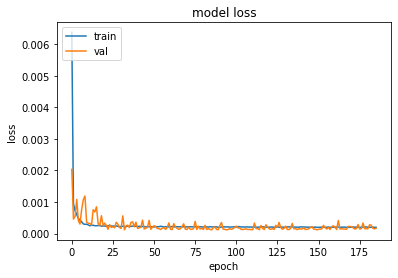

In [44]:
history = pd.read_csv("resources/model/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

5.395666812546551e-05

In [52]:
index = 3
sample = np.array([x_test[index]])

y_sample = scaler.inverse_transform([[y_test[index]] * 5 + [y_test[index]]])
print(y_sample[0][-1])
prediction = model.predict(sample)[0][0]
data = scaler.inverse_transform([[prediction] * 5 + [prediction]])
print(data[0][-1])



13259.52
1/1 [==============================] - 0s 42ms/step
13349.548144509792
